# SCA
### KO K00370 (nar)


In [1]:
import os
from Bio import AlignIO
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import tqdm.notebook as tqdm
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

In [2]:
SEED = None
rng = np.random.default_rng(seed=SEED)

In [3]:
OUTDIR = "../out/sca/K00370"
os.makedirs(OUTDIR, exist_ok=True)

In [4]:
# Convert letters to numbers (0-20 for gap + AAs)
AA_TO_INT = {aa: i for i, aa in enumerate("ACDEFGHIKLMNPQRSTVWY-")}
GAP = AA_TO_INT["-"]

AA_LIST = np.sort([k for k in AA_TO_INT.keys() if k != "-"])

NUM_AAS = len(AA_TO_INT)  # 20 amino acids + gap

assert NUM_AAS == 21, "Should have 20 amino acids and 1 gap marker"
assert GAP == 20, f"GAP index should equal 20. Got {GAP}"

In [5]:
# Load MSA
msa_text = AlignIO.read("../out/aaseqs/K00370/MSA_800_with_reference.aln-fasta", "fasta")
# msa_text = AlignIO.read("./aligned_hits.fasta", "fasta")
# msa_text = [SeqRecord(Seq(str(r.seq).upper()), id=r.id, description=r.description) for r in msa_text]

msa = np.array([[AA_TO_INT[aa] for aa in record.seq] for record in msa_text])
msa_ids = [record.id for record in msa_text]

print(f"MSA shape: {msa.shape} (sequences x positions)")

# Store original state of MSA
MSA_ORIG = msa.copy()
NUM_SEQS, NUM_POS = MSA_ORIG.shape

retained_sequences = np.arange(NUM_SEQS)
retained_positions = np.arange(NUM_POS)

MSA shape: (119, 1417) (sequences x positions)


In [6]:
msa

array([[20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ...,  8,  5,  0],
       ...,
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20],
       [20, 20, 20, ..., 20, 20, 20]], shape=(119, 1417))

In [7]:
xmsa = np.eye(21, dtype=bool)[msa][:,:,:-1]

In [8]:
# Remove columns (i.e. positions) with too many gaps

thresh = 0.5
gapfreqs = np.sum(msa == GAP, axis=0) / msa.shape[0]
screen = gapfreqs < thresh
msa = msa[:,screen]  # keep columns with gap freq < thresh
xmsa = xmsa[:,screen,:]
retained_positions = retained_positions[screen]

print(f"MSA shape: {msa.shape} (sequences x positions)")
assert len(retained_positions) == msa.shape[1], "Mismatch"

MSA shape: (119, 1229) (sequences x positions)


In [9]:
# Remove rows (i.e. sequences) with too many gaps

thresh = 0.5
gapfreqs = np.sum(msa == GAP, axis=1) / msa.shape[1]
screen = gapfreqs < thresh
msa = msa[screen,:]  # keep rows with gap freq < thresh
xmsa = xmsa[screen,:,:]
msa_ids = np.array([s for i, s in enumerate(msa_ids) if screen[i]])
retained_sequences = retained_sequences[screen]

print(f"MSA shape: {msa.shape} (sequences x positions)")
assert len(retained_sequences) == msa.shape[0], "Mismatch"

MSA shape: (119, 1229) (sequences x positions)


In [10]:
# Compare to reference
REF_IDX = np.where(msa_ids == "reference")[0][0]
REF_IDX

np.int64(8)

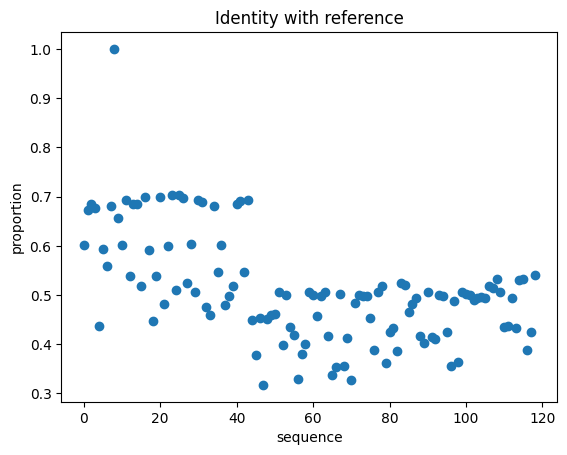

In [11]:
refrow = msa[REF_IDX,:]

sim_ref = np.sum(msa == refrow, axis = 1) / msa.shape[1]
fig, ax = plt.subplots(1, 1)
ax.plot(sim_ref, 'o')
ax.set_xlabel(f"sequence")
ax.set_ylabel(f"proportion")
ax.set_title("Identity with reference")

plt.show()

In [12]:
# Compute sequence weights

thresh = 1.0
ws = np.nan * np.ones(msa.shape[0])

for i, s in enumerate(msa):
    similarities = np.sum(s == msa, axis=1) / msa.shape[1]
    screen = similarities >= thresh
    ws[i] = 1 / screen.sum()

In [13]:
# Remove positions with too many (weighted) gaps

thresh = 0.25

fi0 = np.sum(ws[:,None] * (msa == GAP), axis=0) / ws.sum()
screen = fi0 < thresh
msa = msa[:,screen]
xmsa = xmsa[:,screen,:]
retained_positions = retained_positions[screen]

print(f"MSA shape: {msa.shape} (sequences x positions)")
assert len(retained_positions) == msa.shape[1], "Mismatch"

MSA shape: (119, 984) (sequences x positions)


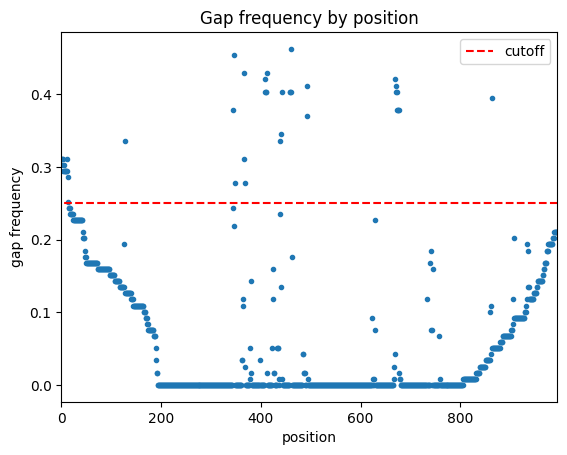

In [14]:
fig, ax = plt.subplots(1, 1)
ax.plot(fi0, ".")
ax.hlines(thresh, *ax.get_xlim(), linestyle='--', color="r", label="cutoff")

ax.legend()
ax.set_xlim(0, 10 + msa.shape[1])

ax.set_xlabel(f"position")
ax.set_ylabel(f"gap frequency")
ax.set_title(f"Gap frequency by position")

plt.show()

In [15]:
# Re-compute sequence weights

thresh = 1.0
ws = np.nan * np.ones(msa.shape[0])

for i, s in enumerate(msa):
    similarities = np.sum(s == msa, axis=1) / msa.shape[1]
    screen = similarities >= thresh
    ws[i] = 1 / screen.sum()

print(f"Effective sample size (sum of weights): {ws.sum()}")

Effective sample size (sum of weights): 119.0


In [16]:
# Compute positional conservation

lam = 0.03
ws_norm = ws / ws.sum()

fi0 = 1 - np.sum(ws[:,None,None] * xmsa, axis=(0,2)) / ws.sum()
fia = (1 - lam) * np.sum(ws_norm[:,None,None] * xmsa, axis=0) + lam / 21

In [17]:
# Compute correlated conservation

fijab = np.nan * np.ones([msa.shape[1], msa.shape[1], 20, 20])

for i in tqdm.trange(msa.shape[1]):
    ci = xmsa[:,i,:]
    for j in range(i, msa.shape[1]):
        cj = xmsa[:,j,:]
        f = (1 - lam) * (ci.T @ (ws_norm[:, None] * cj)) + lam / 21**2
        fijab[i,j,:,:] = f
        fijab[j,i,:,:] = f.T


  0%|          | 0/984 [00:00<?, ?it/s]

In [18]:
# Example background frequencies (Jones et al., 1992)
background = {
    'A': 0.078, 'C': 0.020, 'D': 0.053, 'E': 0.063,
    'F': 0.039, 'G': 0.072, 'H': 0.023, 'I': 0.053,
    'K': 0.059, 'L': 0.091, 'M': 0.022, 'N': 0.043,
    'P': 0.052, 'Q': 0.042, 'R': 0.051, 'S': 0.071,
    'T': 0.058, 'V': 0.066, 'W': 0.014, 'Y': 0.033
}

qa = np.zeros(20)
for a in background:
    qa[AA_TO_INT[a]] = background[a]    
qa = qa / qa.sum()

# TODO: Compare this background with empirical background

In [19]:
Dia = np.nan * np.ones([msa.shape[1], 20])
Dia[:] = fia * np.log(fia / qa) + (1 - fia) * np.log((1 - fia) / (1 - qa))

Di = np.sum(fia * np.log(fia / qa), axis=1)

In [20]:
# Store the top conserved positions in the original alignment
N_TOP_CONSERVED = 10
top_conserved_idxs = np.argsort(Di)[-N_TOP_CONSERVED:]
top_conserved_positions = retained_positions[top_conserved_idxs]


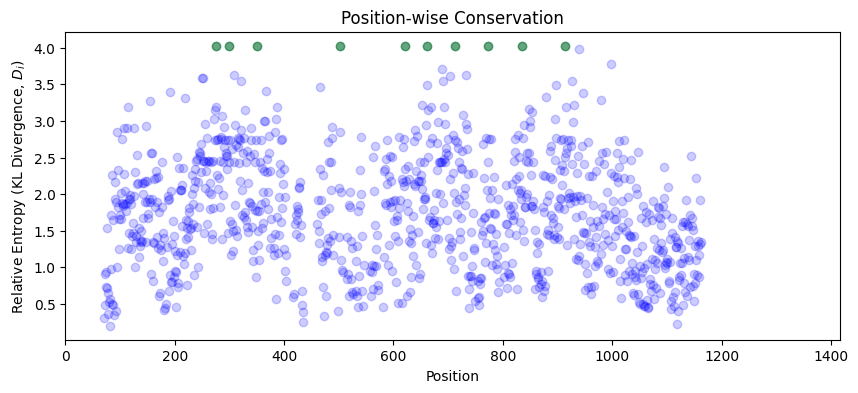

In [21]:
# Plot conservation
fig, ax = plt.subplots(1, 1, figsize=(10,4))

ax.plot(
    retained_positions, Di, "o",
    color="Blue",
    alpha=0.2
)

ax.plot(
    top_conserved_positions, Di[top_conserved_idxs], "o",
    color="Green",
    alpha=0.5
)

ax.set_xlim(0, NUM_POS)
ax.set_xlabel(f"Position")
plt.ylabel("Relative Entropy (KL Divergence, $D_i$)")
ax.set_title(f"Position-wise Conservation")

plt.show()

In [22]:
Cijab_raw = fijab - fia[:,None,:,None] * fia[None,:,None,:]
Cij_raw = np.sqrt(np.sum(np.square(Cijab_raw), axis=(-1, -2)))
assert np.allclose(Cij_raw, Cij_raw.T)


In [23]:
# Apply correction

phi_ia = np.log((fia * (1 - qa)) / ((1 - fia) * qa))
Cijab_corr = phi_ia[:,None,:,None] * phi_ia[None,:,None,:] * Cijab_raw
Cij = np.sqrt(np.sum(np.square(Cijab_corr), axis=(-1,-2)))

In [24]:
# Eigendecomposition of C_ij (raw and corrected)

evals_sca_raw, evecs_sca_raw = np.linalg.eigh(Cij_raw)
evals_sca_raw = np.flip(evals_sca_raw)
evecs_sca_raw = np.flip(evecs_sca_raw, axis=1)

evals_sca, evecs_sca = np.linalg.eigh(Cij)
evals_sca = np.flip(evals_sca)
evecs_sca = np.flip(evecs_sca, axis=1)

print(f"      Eigenvalue spectrum of Cij (raw): " + 
      f"{evals_sca_raw.min():.3g}, {evals_sca_raw.max():.3f}")
print(f"Eigenvalue spectrum of Cij (corrected): " + 
      f"{evals_sca.min():.3g}, {evals_sca.max():.3f}")

      Eigenvalue spectrum of Cij (raw): -1.11, 84.000
Eigenvalue spectrum of Cij (corrected): -12.4, 518.062


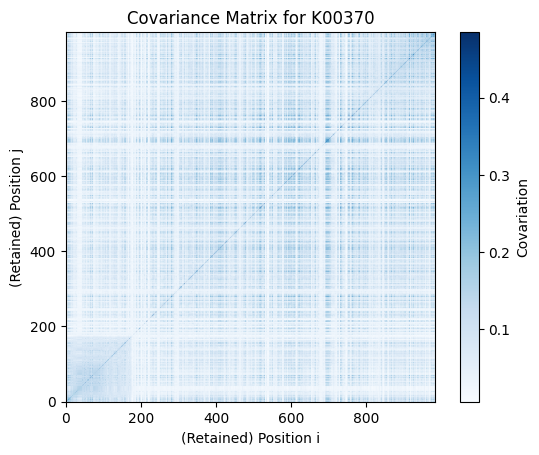

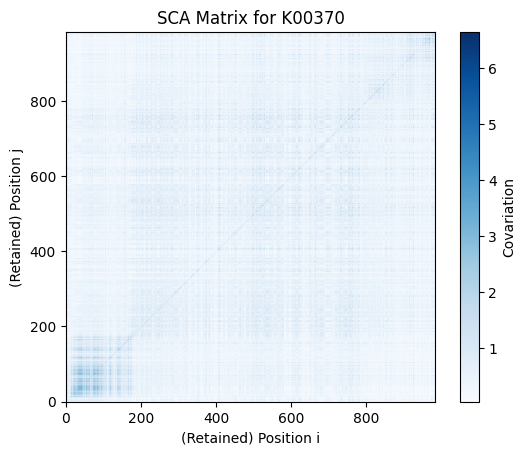

In [25]:
fig, ax = plt.subplots(1, 1)

sc = ax.imshow(
    Cij_raw, 
    cmap="Blues", 
    origin="lower",
    vmax=None,
)

fig.colorbar(sc, label="Covariation")
ax.set_xlabel("(Retained) Position i")
ax.set_ylabel("(Retained) Position j")
ax.set_title("Covariance Matrix for K00370")


fig, ax = plt.subplots(1, 1)

sc = ax.imshow(
    Cij, 
    cmap="Blues", 
    origin="lower",
    vmax=None,
)

fig.colorbar(sc, label="Covariation")
ax.set_xlabel("(Retained) Position i")
ax.set_ylabel("(Retained) Position j")
ax.set_title("SCA Matrix for K00370")

plt.show()

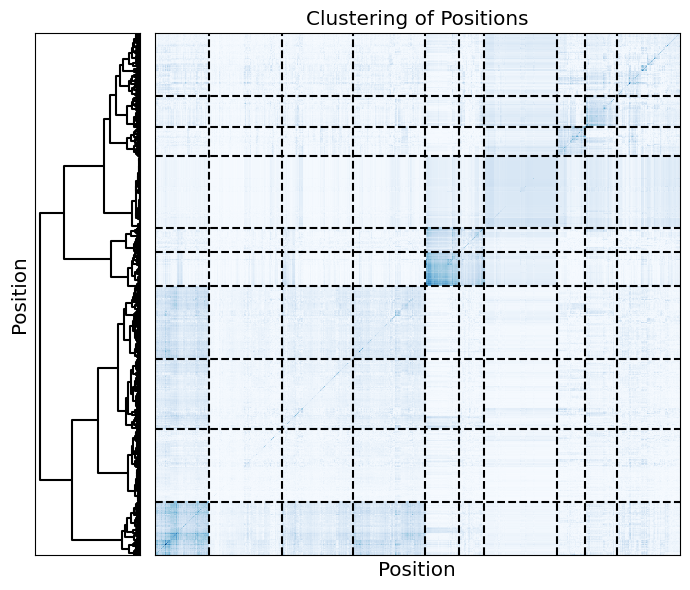

In [26]:

Z = linkage(pdist(Cij, metric='euclidean'), method='ward')

n_clusters = 10
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')


dendro = dendrogram(Z, no_plot=True)
leaf_indices = dendro['leaves']


cmap = plt.cm.turbo
cluster_colors = [to_hex(cmap(i)) for i in np.linspace(0, 1, n_clusters)]

def color_func(link_idx):
    if link_idx < len(clusters):  # Only color leaf nodes
        return cluster_colors[clusters[link_idx] - 1]
    return "#000000"


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 6), 
                               gridspec_kw={'width_ratios': [0.2, 1]})


dendrogram(
    Z,
    orientation='left',
    ax=ax1,
#    color_threshold=max(Z[-n_clusters+1, 2], 0.1),
    link_color_func=color_func,
    above_threshold_color='k'
)

ax1.set_ylabel('Position', fontsize='x-large')
ax1.set_xticks([])
ax1.set_yticks([])


rearranged_data = Cij[leaf_indices][:, leaf_indices]
im = ax2.imshow(
    rearranged_data, 
    aspect='auto', 
    cmap='Blues',
    interpolation='nearest', 
    origin='lower', 
    # vmin=0, vmax=1,
)


boundaries = np.where(np.diff(clusters[leaf_indices]))[0]
for b in boundaries:
    ax2.axhline(b + 0.5, color='black', linestyle='--')
    ax2.axvline(b + 0.5, color='black', linestyle='--')

ax2.set_title('Clustering of Positions', fontsize='x-large')
ax2.set_xlabel('Position', fontsize='x-large')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

In [27]:
from Bio import SeqIO
fasta_fpath = "../out/aaseqs/K00370/800_seqs.fasta"
fastaseqs = SeqIO.parse(fasta_fpath, "fasta")
fastaseqs = {str(e.id): e  for e in fastaseqs}
fastaseqs

{'Soil11.scaffold_431547323_c1_2': SeqRecord(seq=Seq('MSADRFKDEPCRGRCDWEEFYRNRWQYDKVVRSTHGVNCTGSCSWMVHVKDGIV...DEA'), id='Soil11.scaffold_431547323_c1_2', name='Soil11.scaffold_431547323_c1_2', description='Soil11.scaffold_431547323_c1_2', dbxrefs=[]),
 'Soil11.scaffold_587233302_c1_1': SeqRecord(seq=Seq('MSHFLDRLKFFNRPKETFSDGHGAVVHEDRTWENAYRQRWQHDKIVRSTHGVNC...ASV'), id='Soil11.scaffold_587233302_c1_1', name='Soil11.scaffold_587233302_c1_1', description='Soil11.scaffold_587233302_c1_1', dbxrefs=[]),
 'Soil11.scaffold_65427810_c1_20': SeqRecord(seq=Seq('MRSPLDSPRFFRRIARSAEGWSELAPRGREWERLYRERWEHTRIVRSTHGVNCT...VSY'), id='Soil11.scaffold_65427810_c1_20', name='Soil11.scaffold_65427810_c1_20', description='Soil11.scaffold_65427810_c1_20', dbxrefs=[]),
 'Soil11.scaffold_538017197_c1_1': SeqRecord(seq=Seq('IPAMSMVSYAAGTRFLSLIGGVILSFYDWYADLPPASPQVFGDQTDVPESADWY...VVF'), id='Soil11.scaffold_538017197_c1_1', name='Soil11.scaffold_538017197_c1_1', description='Soil11.scaffold_538017197_c1_1', d

In [28]:
# From conserved MSA indices, determine the corresponding residue index in the 
# original fasta file for the protein. That is, map MSA index to AA index per 
# protein.

print("Top conserved positions:", top_conserved_positions)
print("All top conserved positions retained in subsetting?", 
      np.all(np.isin(top_conserved_positions, retained_positions)))

conserved_aa_idxs = -np.ones([len(msa), N_TOP_CONSERVED], dtype=int)
for i, entry in enumerate(msa_text):
    id = entry.id
    aligned_seq = str(entry.seq)
    aa_screen = np.array([c != "-" for c in aligned_seq], dtype=bool)
    n = aa_screen.sum()
    if id in fastaseqs:
        orig_seq = fastaseqs[id]
        if len(orig_seq) != n:
            print(f"Warning. Expected length {len(orig_seq)}. Got {n}.")
    # positions in msa that are not gaps
    msa_aa_idxs = np.arange(len(aligned_seq))[aa_screen]
    if not np.all(np.isin(top_conserved_positions, msa_aa_idxs)):
        print(f"Some conserved positions not found in aligned sequence {id}!")
    aa_positions_in_seq = np.where(np.isin(msa_aa_idxs, top_conserved_positions))[0]
    conserved_aa_idxs[i,:] = aa_positions_in_seq


Top conserved positions: [835 773 299 713 914 275 662 621 350 502]
All top conserved positions retained in subsetting? True


In [29]:
from Bio.PDB import PDBParser
import os

pdbdir = "../out/structure/K00370"
parser = PDBParser(QUIET=True)

pdb_mappings = {}
missing_scaffolds = []
for i, entry in enumerate(msa_text):
    id = entry.id
    aligned_seq = str(entry.seq)
    conserved_positions = conserved_aa_idxs[i]
    pdbfpath = f"{pdbdir}/{id}.pdb"
    if not os.path.isfile(pdbfpath):
        print(f"No PDB file for scaffold: {id}")
        if id in fastaseqs:
            missing_scaffolds.append(fastaseqs[id])
        continue
    structure = parser.get_structure("prot", pdbfpath)
    # Assuming single chain
    chain = next(structure.get_chains())
    # Map sequence indices to PDB residue numbers
    residues = [r for r in chain.get_residues() if r.id[0] == " "]
    conserved_residues = [residues[i] for i in conserved_positions]
    conserved_residue_positions = np.array(
        [r['CA'].coord for r in conserved_residues]
    )
    pdb_mappings[id] = conserved_residue_positions

No PDB file for scaffold: Soil15.scaffold_1154465524_c1_1
No PDB file for scaffold: Soil11.scaffold_356766832_c1_1
No PDB file for scaffold: Soil17.scaffold_349296708_c1_1
No PDB file for scaffold: Soil6.scaffold_640761477_c1_1
No PDB file for scaffold: reference
No PDB file for scaffold: Soil11.scaffold_150019973_c1_1
No PDB file for scaffold: Soil6.scaffold_654612876_c1_1
No PDB file for scaffold: Soil6.scaffold_441881540_c1_4
No PDB file for scaffold: Soil9.scaffold_295701656_c1_1
No PDB file for scaffold: Soil16.scaffold_718712853_c1_1
No PDB file for scaffold: Soil14.scaffold_845528592_c1_1
No PDB file for scaffold: Soil12.scaffold_666676376_c1_1
No PDB file for scaffold: Soil15.scaffold_674474608_c1_1
No PDB file for scaffold: Soil6.scaffold_645328969_c1_1
No PDB file for scaffold: Soil3.scaffold_46704472_c1_7
No PDB file for scaffold: Soil9.scaffold_276334697_c1_1
No PDB file for scaffold: Soil16.scaffold_1328109982_c1_1
No PDB file for scaffold: Soil12.scaffold_24692167_c1_1
No

In [30]:
missingdir = f"{OUTDIR}/missing_seqs"
os.makedirs(missingdir, exist_ok=True)

NFILES_PER_AF_BATCH = 5
subdir = f"{missingdir}/alphafold_batches_K00370_missing"
os.makedirs(subdir, exist_ok=True)
counter = 1
for i, record in enumerate(missing_scaffolds):
    if i % NFILES_PER_AF_BATCH == 0:
        outdir = f"{subdir}/alphafold_K00370_missing_batch{counter}"
        counter += 1
    os.makedirs(outdir, exist_ok=True)
    SeqIO.write(record, f"{outdir}/{record.id}.fasta", "fasta")


In [31]:
pdb_mappings

{'Soil14.scaffold_576820813_c1_40': array([[  6.115,   1.72 ,   3.431],
        [ -7.736,  11.177, -19.186],
        [  7.746,  21.83 , -20.164],
        [-24.737,  11.683,   6.666],
        [  8.087,  34.334,  -5.411],
        [  9.557,  13.49 ,  -0.395],
        [-12.865, -17.294,  11.271],
        [ -3.319,   5.814,  16.882],
        [  6.759, -13.427,  -0.638],
        [  2.551, -16.206, -13.241]], dtype=float32),
 'Soil14.scaffold_280216268_c1_12': array([[ -1.898,   5.21 ,   5.689],
        [ -3.264, -14.026, -14.819],
        [-17.432, -19.916,  -3.908],
        [ 24.856, -11.66 ,  -2.214],
        [-10.714, -26.754,  13.216],
        [ -7.878,  -5.759,   8.989],
        [ 19.524,  19.715,  -4.994],
        [ 13.094,   2.845,  13.321],
        [ -3.506,  18.006,  -3.321],
        [ -6.623,  15.606, -16.297]], dtype=float32),
 'Soil6.scaffold_312871021_c1_4': array([[  0.207,   8.386,  -3.335],
        [ -9.273, -17.284,   3.125],
        [-24.584, -10.023,  -4.907],
        [  2

In [32]:
# Compute pairwise distance matrix for conserved positions.

ncombs = N_TOP_CONSERVED * (N_TOP_CONSERVED - 1) // 2
all_pdists = np.nan * np.ones([len(pdb_mappings), ncombs])

for i, id in enumerate(sorted(list(pdb_mappings.keys()))):
    x = pdb_mappings[id]
    dists = pdist(x, metric="euclidean")
    all_pdists[i] = dists

Text(0, 0.5, 'Distance (Angstroms)')

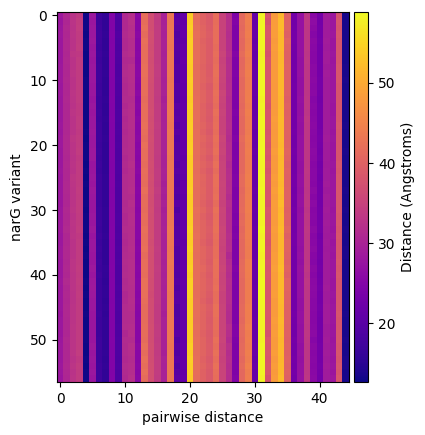

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1)

sc = ax.imshow(all_pdists, cmap = 'plasma')
plt.ylabel('narG variant')
plt.xlabel('pairwise distance')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.set_ylabel("Distance (Angstroms)")


[0.23254333 0.15472308 0.1291633  0.09912635 0.07326236 0.0486234
 0.04387498 0.03910113 0.03242282 0.02969856 0.02388031 0.02073566
 0.0168917  0.01232003 0.01018576 0.00939102 0.00630662 0.00382589
 0.00359251 0.00340948]
[24.42280993 19.92146311 18.20175445 15.94550349 13.70831678 11.16776691
 10.60845582 10.0147087   9.1194593   8.72793215  7.82642955  7.29293878
  6.58234169  5.62146522  5.11140548  4.90794808  4.02200047  3.13263521
  3.03558653  2.9572471 ]


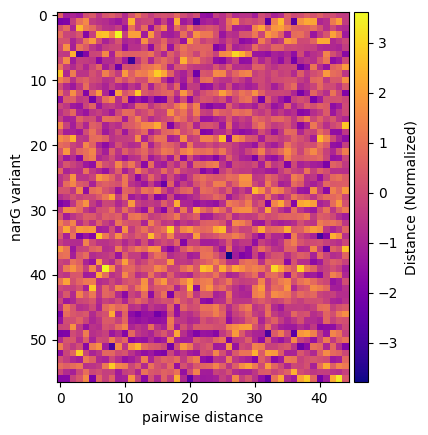

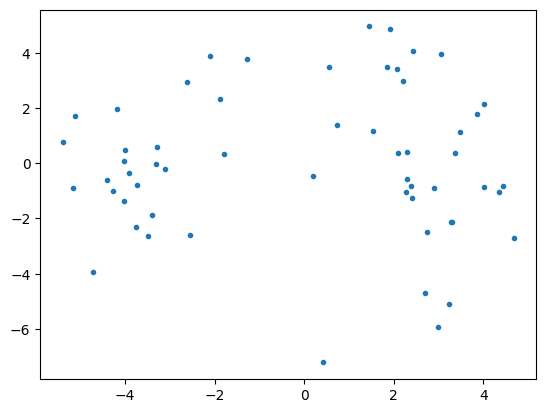

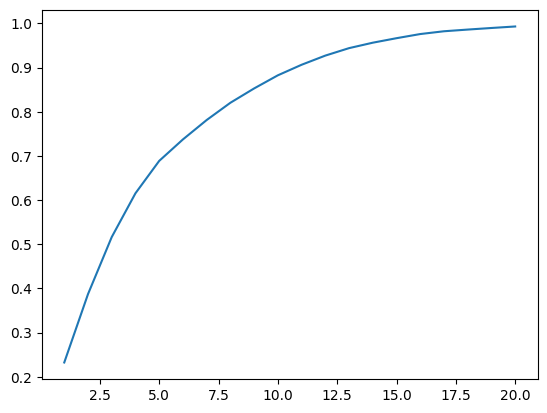

In [34]:
from sklearn.decomposition import PCA

all_pdists_centered = (all_pdists - all_pdists.mean(0)) / all_pdists.std(0)

fig, ax = plt.subplots(1, 1)

sc = ax.imshow(all_pdists_centered, cmap = 'plasma')
plt.ylabel('narG variant')
plt.xlabel('pairwise distance')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig = ax.figure
cbar = fig.colorbar(sc, cax=cax)
cbar.ax.set_ylabel("Distance (Normalized)")

pca = PCA(n_components=20)
pca.fit(all_pdists_centered)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
data_pca = pca.transform(all_pdists_centered)

fig, ax = plt.subplots(1, 1)
ax.plot(
    data_pca[:,0], data_pca[:,1], "."

)

fig, ax = plt.subplots(1, 1)
ax.plot(
    1 + np.arange(len(pca.explained_variance_ratio_)), 
    np.cumsum(pca.explained_variance_ratio_)
)

plt.show()

In [35]:
# Eigendecomp of SCA matrix compared to randomized version

def run_sca(
        xmsa,
        ws,
        background,
        qa=None,
        lam=0.03,  # regularization
        pbar=True,
        leave_pbar=True,
):
    results = {}

    nseq, npos, naas = xmsa.shape

    # Compute positional conservation
    ws_norm = ws / ws.sum()
    fi0 = 1 - np.sum(ws[:,None,None] * xmsa, axis=(0,2)) / ws.sum()
    fia = (1 - lam) * np.sum(ws_norm[:,None,None] * xmsa, axis=0) + lam / 21

    # Compute correlated conservation
    fijab = np.full([npos, npos, naas, naas], np.nan)
    for i in tqdm.trange(npos, disable=not pbar, leave=leave_pbar):
        ci = xmsa[:,i,:]
        for j in range(i, npos):
            cj = xmsa[:,j,:]
            f = (1 - lam) * (ci.T @ (ws_norm[:, None] * cj)) + lam / 21**2
            fijab[i,j,:,:] = f
            fijab[j,i,:,:] = f.T

    if qa is None:
        qa = np.zeros(naas)
        for a in background:
            qa[AA_TO_INT[a]] = background[a]    
        qa = qa / qa.sum()

    Dia = np.nan * np.ones([npos, naas])
    Dia[:] = fia * np.log(fia / qa) + (1 - fia) * np.log((1 - fia) / (1 - qa))
    Di = np.sum(fia * np.log(fia / qa), axis=1)

    Cijab_raw = fijab - fia[:,None,:,None] * fia[None,:,None,:]
    Cij_raw = np.sqrt(np.sum(np.square(Cijab_raw), axis=(-1, -2)))
    # Cij_raw = (Cij_raw + Cij_raw.T) / 2
    phi_ia = np.log((fia * (1 - qa)) / ((1 - fia) * qa))
    Cijab_corr = phi_ia[:,None,:,None] * phi_ia[None,:,None,:] * Cijab_raw
    Cij = np.sqrt(np.sum(np.square(Cijab_corr), axis=(-1,-2)))
    # Cij = (Cij + Cij.T) / 2

    results["fi0"] = fi0
    results["fijab"] = fijab
    results["Dia"] = Dia
    results["Di"] = Di
    results["Cijab_raw"] = Cijab_raw
    results["Cij_raw"] = Cij_raw
    results["phi_ia"] = phi_ia
    results["Cijab_corr"] = Cijab_corr
    results["Cij_corr"] = Cij

    return results


In [36]:
niters = 50

def shuffle_columns(m, rng=None):
    rng = np.random.default_rng(rng)
    r, c = m.shape
    idx = np.argsort(rng.random((r, c)), axis=0)
    return m[idx, np.arange(c)]


DO_SHUFFLING = False
SHUFFLE_SEED = 13243
shuffling_saveas = f"{OUTDIR}/shuffled_cijs_corrected.npy"

if DO_SHUFFLING:
    rng_shuffler = np.random.default_rng(SHUFFLE_SEED)
    cijs_shuffled = np.full([niters, *Cij.shape], np.nan)
    for iteridx in tqdm.trange(niters):
        msa_shuff = shuffle_columns(msa, rng=rng_shuffler)
        xmsa_shuff = np.eye(21, dtype=bool)[msa_shuff][:,:,:-1]
        res = run_sca(xmsa_shuff, ws, background, leave_pbar=False)
        cijs_shuffled[iteridx] = res["Cij_corr"]

    np.save(shuffling_saveas, cijs_shuffled)
else:
    cijs_shuffled = np.load(shuffling_saveas)

In [37]:
evals_shuff = np.full([len(cijs_shuffled), *evals_sca.shape], np.nan)
for i, cij_shuff in enumerate(cijs_shuffled):
    evals = np.linalg.eigvalsh(cij_shuff)
    evals_shuff[i] = np.flip(evals)

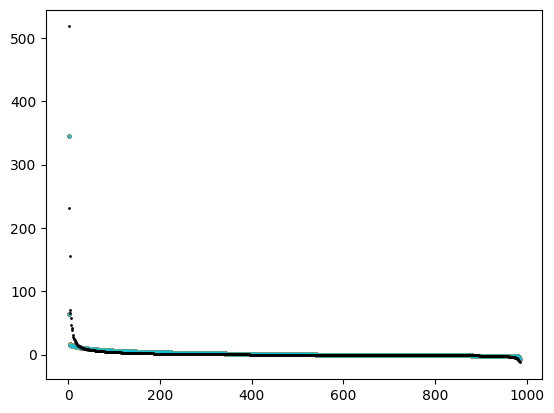

In [38]:
fig, ax = plt.subplots(1, 1)

for e in evals_shuff:
    ax.plot(
        1 + np.arange(len(e)), e, ".",
        markersize=3
    )


ax.plot(
    1 + np.arange(len(evals_sca)), evals_sca,
    "k.",
    markersize=2
)

significant eigenvalue cutoff: 63.7429249888581
5 significant eigenvalues: [518.06194821 230.97033132 155.83063544  71.24253802  66.17313831]


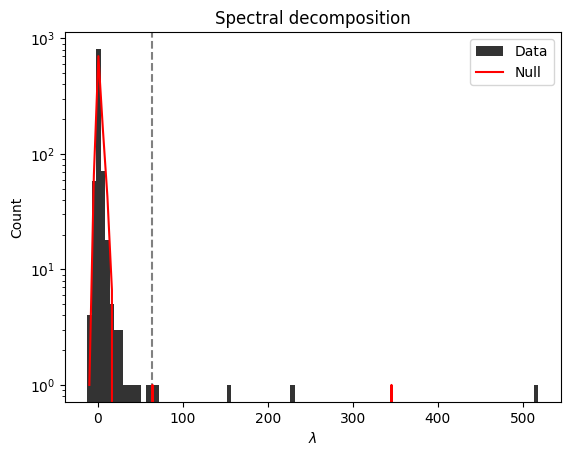

In [39]:
fig, ax = plt.subplots(1, 1)

# Histogram of data eigenvalues
counts, bins, patches = ax.hist(
    evals_sca, bins=100, color="black", alpha=0.8, log=True, label="Data"
)

cutoff = np.mean(evals_shuff[:,1]) + 2 * np.std(evals_shuff[:,1])  # See SI G of [1]
print("significant eigenvalue cutoff:", cutoff)

kstar = np.sum(evals_sca > cutoff)
sig_evals_sca = evals_sca[:kstar]
sig_evecs_sca = evecs_sca[:,:kstar]
print(f"{kstar} significant eigenvalues:", sig_evals_sca)


# Null distribution
bin_centers = 0.5 * (bins[1:] + bins[:-1])
h, bin_edges = np.histogram(evals_shuff.flatten(), bins=bins)
ax.axvline(cutoff, 0, 1, linestyle="--", color="grey")
ax.plot(bin_centers, h / niters, color="red", lw=1.5, label="Null")

ax.legend()
ax.set_xlabel(f"$\\lambda$")
ax.set_ylabel(f"Count")
ax.set_title(f"Spectral decomposition")

plt.show()

In [40]:
def apply_ica(v, rho=1e-4, tol=1e-7, maxiter=1000000):
    k, m = v.shape
    id = np.eye(k)
    w = np.eye(k)
    dw = 100.
    itercount = 0
    while itercount < maxiter:
        y = w @ v
        g = 1 / (1 + np.exp(-y))
        dw = rho * (id + (1 - 2 * g) @ y.T) @ w
        w += dw
        if np.max(np.abs(dw)) < tol:
            print(f"Converged in {itercount} iterations")
            return w
        itercount += 1
    print(f"Did not converge in {maxiter} iterations")

w_ica = apply_ica(sig_evecs_sca.T)

v_ica = sig_evecs_sca @ w_ica.T


Converged in 36333 iterations


In [41]:
v_ica_normalized = v_ica / np.sqrt(np.sum(np.square(v_ica), axis=0))
for i in range(v_ica.shape[1]):
    maxpos = np.argmax(np.abs(v_ica_normalized[:,i]))
    if v_ica_normalized[maxpos,i] < 0:
        v_ica_normalized[:,i] *= -1

In [42]:
# Get groups

groups = []

for i in range(v_ica_normalized.shape[1]):
    top95 = np.where(v_ica_normalized[:,i] >= np.percentile(v_ica_normalized[:,i], 95))[0]
    groups.append(top95)


In [43]:
groups

[array([  5,  71,  82,  96, 105, 156, 188, 204, 214, 216, 227, 237, 250,
        282, 316, 347, 374, 405, 407, 409, 431, 451, 452, 496, 498, 506,
        510, 517, 528, 541, 563, 572, 610, 618, 619, 648, 662, 664, 734,
        741, 751, 752, 753, 755, 759, 762, 763, 779, 852, 924]),
 array([ 19,  20,  23,  25,  30,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  47,  48,  50,  54,  55,  57,  60,  61,  62,
         69,  72,  73,  74,  75,  76,  78,  79,  83,  84,  85,  87,  88,
         91,  95,  98, 117, 118, 135, 136, 138, 139, 142, 145]),
 array([ 15,  19,  20,  22,  23,  25,  26,  29,  30,  31,  32,  33,  34,
         35,  36,  37,  38,  39,  40,  41,  42,  43,  47,  48,  50,  54,
         55,  57,  60,  61,  62,  69,  72,  73,  74,  75,  76,  78,  79,
         83,  84,  85,  87,  88,  91,  94,  95,  98, 118, 145]),
 array([ 53, 106, 221, 235, 244, 292, 293, 308, 332, 408, 441, 483, 494,
        495, 522, 524, 532, 542, 546, 552, 558, 566, 615, 671, 672, 704,
  

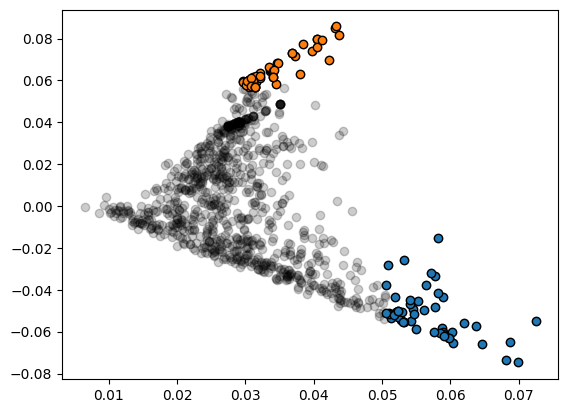

In [44]:
fig, ax = plt.subplots(1, 1)

sc = ax.scatter(
    v_ica_normalized[:,0], v_ica_normalized[:,1],
    c='k', 
    # s=sizes, 
    # cmap='viridis', 
    alpha=0.2, 
    edgecolor='k'
)

for i, g in enumerate(groups[0:2]):
    ax.scatter(
        v_ica_normalized[g,0], v_ica_normalized[g,1],
        # c=colors, 
        # s=sizes, 
        # cmap='viridis', 
        alpha=1, 
        edgecolor='k'
    )

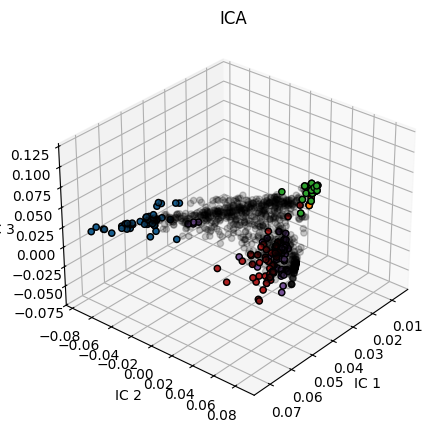

In [45]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    v_ica_normalized[:,0], v_ica_normalized[:,1], v_ica_normalized[:,2], 
    c="k", 
    # s=sizes, 
    # cmap='viridis', 
    alpha=0.2, 
    edgecolor='k'
)

for i, g in enumerate(groups):
    ax.scatter(
        v_ica_normalized[g,0], v_ica_normalized[g,1], v_ica_normalized[g,2], 
        # c=colors, 
        # s=sizes, 
        # cmap='viridis', 
        alpha=1, 
        edgecolor='k'
    )

# ax.scatter(0, 0, 0, "r")

ax.set_xlabel(f"IC 1")
ax.set_ylabel(f"IC 2")
ax.set_zlabel(f"IC 3")
ax.set_title(f"ICA")

ax.view_init(elev=30, azim=40)   # elev ~ tilt, azim ~ around z; tweak to taste
# ax.set_proj_type('persp')

# plt.tight_layout()
plt.show()


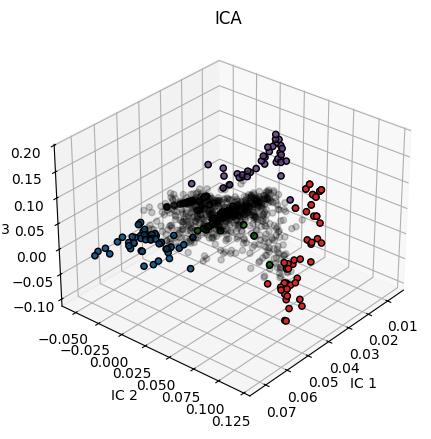

In [46]:

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    v_ica_normalized[:,0], v_ica_normalized[:,3], v_ica_normalized[:,4], 
    c="k", 
    # s=sizes, 
    # cmap='viridis', 
    alpha=0.2, 
    edgecolor='k'
)

for i, g in enumerate(groups):
    ax.scatter(
        v_ica_normalized[g,0], v_ica_normalized[g,3], v_ica_normalized[g,4], 
        # c=colors, 
        # s=sizes, 
        # cmap='viridis', 
        alpha=1, 
        edgecolor='k'
    )

# ax.scatter(0, 0, 0, "r")

ax.set_xlabel(f"IC 1")
ax.set_ylabel(f"IC 2")
ax.set_zlabel(f"IC 3")
ax.set_title(f"ICA")

ax.view_init(elev=30, azim=40)   # elev ~ tilt, azim ~ around z; tweak to taste
# ax.set_proj_type('persp')

# plt.tight_layout()
plt.show()


In [47]:
# Save groups after converting to corresponding tertiary position

group_idxs_in_msa_by_entry = []
for i, entry in enumerate(msa_text):
    id = entry.id
    aligned_seq = str(entry.seq)
    aa_screen = np.array([c != "-" for c in aligned_seq], dtype=bool)
    n = aa_screen.sum()
    if id in fastaseqs:
        orig_seq = fastaseqs[id]
        if len(orig_seq) != n:
            print(f"Warning. Expected length {len(orig_seq)}. Got {n}.")
    # positions in msa that are not gaps
    msa_aa_idxs = np.arange(len(aligned_seq))[aa_screen]
    group_idxs = []
    for g in groups:
        group_idxs.append(g[np.isin(g, msa_aa_idxs)])
    group_idxs_in_msa_by_entry.append(group_idxs)


In [48]:
group_idxs_in_msa_by_entry[0]

[array([ 71,  82,  96, 105, 156, 188, 204, 214, 216, 227, 237, 250, 282,
        316, 347, 374, 431, 506, 510, 517, 541, 563, 572, 610, 618, 619,
        648, 662, 664, 734, 741, 755, 759, 762, 763, 779, 852, 924]),
 array([ 55,  57,  60,  61,  62,  69,  72,  73,  74,  75,  76,  78,  79,
         83,  84,  85,  87,  88,  91,  95,  98, 117, 118, 135, 136, 138,
        139, 142, 145]),
 array([ 55,  57,  60,  61,  62,  69,  72,  73,  74,  75,  76,  78,  79,
         83,  84,  85,  87,  88,  91,  94,  95,  98, 118, 145]),
 array([106, 221, 235, 244, 292, 293, 308, 332, 483, 522, 524, 532, 542,
        558, 566, 615, 671, 672, 704, 718, 725, 757, 760, 786, 795, 858,
        863, 871, 876, 884, 890, 894, 896, 906, 931, 938, 947, 949, 953,
        955, 960, 969]),
 array([807, 821, 822, 831, 832, 835, 836, 841, 843, 844, 845, 856, 857,
        880, 896, 906, 908, 909, 911, 915, 916, 917, 920, 927, 931, 932,
        938, 939, 942, 947, 949, 951, 955, 956, 957, 960, 962, 963, 965,
        966,

In [49]:
pdbdir = "../out/structure/K00370"
parser = PDBParser(QUIET=True)

savedir = f"{OUTDIR}/sca_groups"

pdb_groups = {}
for i, entry in enumerate(msa_text):
    id = entry.id
    aligned_seq = str(entry.seq)
    group_positions = group_idxs_in_msa_by_entry[i]
    pdbfpath = f"{pdbdir}/{id}.pdb"
    if not os.path.isfile(pdbfpath):
        continue
    subdir = f"{savedir}/{id}"
    os.makedirs(subdir, exist_ok=True)
    structure = parser.get_structure("prot", pdbfpath)
    # Assuming single chain
    chain = next(structure.get_chains())
    # Map sequence indices to PDB residue numbers
    residues = [r for r in chain.get_residues() if r.id[0] == " "]
    residue_groups = []
    for gidx, group in enumerate(group_positions):
        group_residues = [residues[idx] for idx in group]
        group_residue_positions = np.array(
            [r['CA'].coord for r in group_residues]
        )
        residue_groups.append(group_residues)
        np.save(f"{subdir}/group{gidx}.npy", group)
    pdb_groups[id] = residue_groups
    

In [50]:
pdb_groups["Soil14.scaffold_576820813_c1_40"][2]

[<Residue GLY het=  resseq=56 icode= >,
 <Residue CYS het=  resseq=58 icode= >,
 <Residue LYS het=  resseq=61 icode= >,
 <Residue ILE het=  resseq=62 icode= >,
 <Residue PHE het=  resseq=63 icode= >,
 <Residue SER het=  resseq=70 icode= >,
 <Residue MET het=  resseq=73 icode= >,
 <Residue GLN het=  resseq=74 icode= >,
 <Residue GLN het=  resseq=75 icode= >,
 <Residue THR het=  resseq=76 icode= >,
 <Residue ASP het=  resseq=77 icode= >,
 <Residue PRO het=  resseq=79 icode= >,
 <Residue ARG het=  resseq=80 icode= >,
 <Residue ASP het=  resseq=84 icode= >,
 <Residue LEU het=  resseq=85 icode= >,
 <Residue PRO het=  resseq=86 icode= >,
 <Residue HIS het=  resseq=88 icode= >,
 <Residue GLU het=  resseq=89 icode= >,
 <Residue GLY het=  resseq=92 icode= >,
 <Residue ARG het=  resseq=95 icode= >,
 <Residue GLY het=  resseq=96 icode= >,
 <Residue PHE het=  resseq=99 icode= >,
 <Residue LEU het=  resseq=119 icode= >,
 <Residue ARG het=  resseq=146 icode= >]

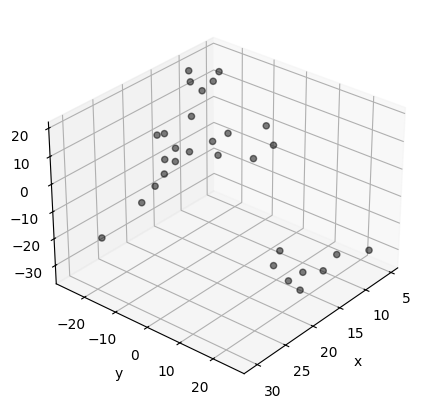

In [51]:

fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111, projection='3d')

xyz = np.array(
    [r['CA'].coord for r in pdb_groups["Soil14.scaffold_596019752_c1_119"][1]]
)

sc = ax.scatter(
    xyz[:,0], xyz[:,1], xyz[:,2], 
    c="k", 
    # s=sizes, 
    # cmap='viridis', 
    alpha=0.5, 
    edgecolor='k'
)


# ax.scatter(0, 0, 0, "r")

ax.set_xlabel(f"x")
ax.set_ylabel(f"y")
ax.set_zlabel(f"z")

ax.view_init(elev=30, azim=40)   # elev ~ tilt, azim ~ around z; tweak to taste
# ax.set_proj_type('persp')

# plt.tight_layout()
plt.show()


In [52]:
# def run_iteration(C, randomize=False):
#     # Compute eigenvalues and eigenvectors
#     if randomize:

#     eigenvalues, eigenvectors = np.linalg.eig(C)

#     # Get sorting order
#     order = np.argsort(eigenvalues)
#     if sort_descending:
#         order = order[::-1]

#     # Sort eigenvalues and eigenvectors
#     eigenvalues = eigenvalues[order]
#     eigenvectors = eigenvectors[:, order]

#     return eigenvalues, eigenvectors
    


# # pca = PCA(n_components=ndim)
# # pca.fit(X)
# # print(pca.explained_variance_ratio_)
# # print(pca.singular_values_)
# # data_pca = pca.transform(X)



In [ ]:
# Assign sectors to the amino acids in the original MSA

sector_assignment = -1 * np.ones(NUM_POS, dtype=int)

In [ ]:
id = msa_text[0].id
seq = msa_text[0].seq
print(id, seq)
print(len([c for c in seq if c != "-"]))
print()

In [ ]:
from Bio import SeqIO

fpath = "../data/interpro/out_K00370/1000_seqs.sto"

alignment = AlignIO.read(fpath, "stockholm")


# Check basic info
print(f"Number of sequences: {len(alignment)}")
print(f"Alignment length: {alignment.get_alignment_length()}")

# Print the first 50 residues of the first sequence
print(alignment[0].id)
seq = alignment[0].seq

trailing_gaps = np.zeros(len(alignment))
for i, record in enumerate(alignment):
    seq_str = str(record.seq)
    # Count trailing gaps
    trailing_gaps[i] = len(seq_str) - len(seq_str.rstrip('-'))
    

# print(f"Loaded {len(records)} sequences")

# # Access first sequence
# print(records[0].id)       # header line (up to first space)
# print(records[0].seq)      # sequence string

# sizes = np.array([len(records[i].seq) for i in range(len(records))])
# idxs = np.argsort(sizes)[-20:]

# for i in idxs:
#     print(records[i].id, len(records[i].seq))


In [ ]:
# np.median(trailing_gaps)
# print(np.sort(trailing_gaps)[0:20])
# print(np.sort(trailing_gaps)[-20:])

# idxs = np.argsort(trailing_gaps)
# for i, idx in enumerate(idxs[0:10]):
#     idx = int(idx)
#     print(idx, trailing_gaps[idx], alignment[int(idx)].id)

In [ ]:
# plt.hist(trailing_gaps, bins=20, log=True)

In [ ]:
# from Bio import AlignIO
# alignment = AlignIO.read(fpath, "stockholm")
# AlignIO.write(alignment, "aligned_hits.fasta", "fasta")
